<h1 align=center><font size = 7>Midnight in Paris</font></h1>

<h2 align=center>Applied Data Sciente Capstone - Coursera Data Science</h2>
<h3 align=center>by Juan Manuel Gelos</h3>
<h3 align=center>August 2020</h3>


---

# 1. Introduction

## 1.1. Background

Midnight Company is a (Fantastic) tematic restaurant looking to open a branch in Paris. They are interested in finding the neighborhood that best suits their charisma: love for antiques.

The restaurant prepares cuisine from all countries, offering a thematic setting and dishes based on different golden periods of each country

Its main concern is to find a place where people and tourists usually enjoy existing restaurants, in areas surrounded with antiques shop

## 1.2 Problem

So, the big question to solve is: What is the best neighborhood in Paris fitting:

•	In first place, has enough antiques shops that assure attraction on target customers
•	In second, has an important presence of restaurants that assure the flow of customers on streets
•	In third place, the selected Neighborhood is better than others with similar cuisines

This project aims to classificate Paris neighborhoods in order to make the best recommendation

##
1.3 Interest
The principal interested is, of course, the Midnight Company. Others who could be interested are antiques shops in Paris and existing restaurants


As we have a preescriptive question, we will use Clasification Approach.
We will use Machine Learning techniques for Clustering Neihborhood to analyze competitors restaurant types

---

# 2. Data
## Data Requirements
We need to analyze neighborhoods in Paris, and use geolocalization to associate neighborhoods with restaurants and antiques shops


We will use Foursquare geolocated data to collect data about restaurants and antiques shops in Paris to analize and segment neighborhoods to find the best

Paris Neiborhoods Names (called Arrondissements) will be scrapped from WikiPedia (https://en.wikipedia.org/wiki/Arrondissements_of_Paris) 

Also, each Neighborhood geolocalization data will be obtained using Nominatim GEOPY geocoder 


---

# 3. Data Collection, Understanding and Preparation

Import required libraries for this Notebook

In [6]:
#Installations

#geopy
    #!conda install -c conda-forge geopy --yes
    #On Windows/Anaconda Prompt use: pip install geopy

#folium
    #!conda install -c conda-forge folium=0.5.0 --yes # install
    #On Windows/Anaconda Prompt use: pip install folium

In [7]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported OK.')

Libraries imported OK.


---

## 3.1. Collect Neighborhoods in Paris

Scrap Wikipedia for Neighborhoods Names

In [8]:
#Scrap Wikipedia
url = "https://en.wikipedia.org/wiki/Arrondissements_of_Paris"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')
table = soup.find('table',{'class':'wikitable sortable'})
dfNeighborhood = pd.read_html(str(table))[0]
dfNeighborhood.head()

,"Arrondissement (R for Right Bank, L for Left Bank)",Name,Area (km2),Population(2017 estimate),Density (2017)(inhabitants per km2),Peak of population,Mayor,2020-2026
0,Paris Centre 1st (Ier) / 2nd (IIe) / 3rd (IIIe...,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS),NaN
1,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),59631,23477,1911,Florence Berthout (DVD),NaN
2,6th (VIe) L,Luxembourg,2.154 km2 (0.832 sq mi),41976,19524,1911,Jean-Pierre Lecoq (LR),NaN
3,7th (VIIe) L,Palais-Bourbon,4.088 km2 (1.578 sq mi),52193,12761,1926,Rachida Dati (LR),NaN
4,8th (VIIIe) R,Élysée,3.881 km2 (1.498 sq mi),37368,9631,1891,Jeanne d'Hauteserre (LR),NaN


Make some Data Cleaning

In [9]:
#Data Cleaning
#Remove unwated columns
dfNeighborhood = dfNeighborhood[['Name']]

# Redefine column names
dfNeighborhood.columns=["Neighborhood"]


Some neightborhood grouped in same row, so we need to split this using this function

In [10]:
#Function to split Neighborhood names grouped in same rows in wikipedia
def tidy_split(df, column, sep='|', keep=False):
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [11]:
dfNeighborhood = tidy_split(dfNeighborhood, 'Neighborhood', sep=',')


In [12]:
#Strip spaces from Names
dfNeighborhood['Neighborhood'] = dfNeighborhood['Neighborhood'].str.strip()

#Reset index
dfNeighborhood.reset_index(inplace= True,drop=True)

And finally we have a clean Neighborhood list:

In [13]:
dfNeighborhood.head()

,Neighborhood
0,Louvre
1,Bourse
2,Temple
3,Hôtel-de-Ville
4,Panthéon


---

## 3.2. Geolocate Neighborhoods in Paris

In [14]:
#GeoLocate each neighborhood using Nominatim
geolocator = Nominatim(user_agent="jm")
for index, row in dfNeighborhood.iterrows():
    address = row['Neighborhood'] + ', Paris, France'
    print('Geolocalizating ' + address + '...')
    location = geolocator.geocode(address)
    dfNeighborhood.at[index, 'Latitude'] = location.latitude
    dfNeighborhood.at[index, 'Longitude']  = location.longitude
    
dfNeighborhood.shape

Geolocalizating Louvre, Paris, France...
Geolocalizating Bourse, Paris, France...
Geolocalizating Temple, Paris, France...
Geolocalizating Hôtel-de-Ville, Paris, France...
Geolocalizating Panthéon, Paris, France...
Geolocalizating Luxembourg, Paris, France...
Geolocalizating Palais-Bourbon, Paris, France...
Geolocalizating Élysée, Paris, France...
Geolocalizating Opéra, Paris, France...
Geolocalizating Entrepôt, Paris, France...
Geolocalizating Popincourt, Paris, France...
Geolocalizating Reuilly, Paris, France...
Geolocalizating Gobelins, Paris, France...
Geolocalizating Observatoire, Paris, France...
Geolocalizating Vaugirard, Paris, France...
Geolocalizating Passy, Paris, France...
Geolocalizating Batignolles-Monceau, Paris, France...
Geolocalizating Butte-Montmartre, Paris, France...
Geolocalizating Buttes-Chaumont, Paris, France...
Geolocalizating Ménilmontant, Paris, France...


(20, 3)

In [15]:
dfNeighborhood.head()

,Neighborhood,Latitude,Longitude
0,Louvre,48.861147,2.338028
1,Bourse,48.868630,2.341474
2,Temple,48.866500,2.360708
3,Hôtel-de-Ville,48.856426,2.352528
4,Panthéon,48.846191,2.346079


### Data Understanding: Neighborhoods Visualization on Paris Map

In [22]:
address = 'Paris, France'
geolocator = Nominatim(user_agent="jm")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


# create map 
map_ba = folium.Map(location=[latitude, longitude], zoom_start=10,width=600,height=400)

# add markers to map
for lat, lng, neighborhood in zip(dfNeighborhood['Latitude'], dfNeighborhood['Longitude'], dfNeighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ba)  

map_ba

---

## 3.3. Collect Antiques Shop in Paris


Define Foursquare Credentials , Versions and Parameters

In [23]:
#CLIENT_ID = 'BG4TACIEB2U1YTBDC3PFEBCRJL32IADQKBPY21YW2TJSXT1R'  
CLIENT_ID = '5JEFZUVW2552RP1UC0XOFYHW3GQX4WCHCSEWJZB5YSHCG2FI'
#CLIENT_SECRET = 'WBJOCDDP12DUL3ZCGZUEGXLVIOLZ3325GUBDQ4VXIIGSZRDF' 
CLIENT_SECRET = 'SUPM4GL5FWXKIOS2KF0NRA1R3X05IJWTF3LGBOEXHO00BZN3'
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # limit of number of venues returned by Foursquare API

Function to get nearby venues filtering by Categories

In [24]:
def getNearbyVenues(names, latitudes, longitudes, categories,radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Collecting nearby venues on ' + name+ '...')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categories)
            
        # make the GET request
        results = requests.get(url).json()
        #FOR DEBUG print(results)
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],        
            v['venue']['id']
        ) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'VenueID']
    
    return(nearby_venues)


Then use the function to create dataframe  for antique shops dataframe

In [25]:
antique_venues = getNearbyVenues(names=dfNeighborhood['Neighborhood'],
                         latitudes=dfNeighborhood['Latitude'],
                         longitudes=dfNeighborhood['Longitude'],
                         categories='4bf58dd8d48988d116951735' 
                         )
print(antique_venues.shape)

(52, 8)


### Understanding Antiques Shops in Paris

Lets group and sort atiques shops to find Neighborhood's Stores

In [26]:
antique_venues_grouped = antique_venues.groupby('Neighborhood').count().sort_values(by=['Venue'], ascending=False).reset_index()
antique_venues_grouped = antique_venues_grouped[['Neighborhood','Venue']]
antique_venues_grouped.columns=["Neighborhood",'AntiqueShops']
antique_venues_grouped.head()

,Neighborhood,AntiqueShops
0,Luxembourg,13
1,Hôtel-de-Ville,8
2,Popincourt,5
3,Observatoire,3
4,Louvre,3


we can see that **Luxembourg has the largest number of antiques shops, followed by Hôtel-de-Ville and Popincourt**

### Merge into Neighborhood

In [27]:
#Merge Neighborhoods dataframe to antiques findings
dfNeighborhood = dfNeighborhood.join(antique_venues_grouped.set_index('Neighborhood'), on='Neighborhood')
#dfNeighborhood

In [28]:
#Cleaning NaN set 0
dfNeighborhood.fillna(0, inplace = True)
dfNeighborhood.AntiqueShops=dfNeighborhood.AntiqueShops.astype(int)
#dfNeighborhood.Likes=dfNeighborhood.Likes.astype(int)

In [29]:
dfNeighborhood

,Neighborhood,Latitude,Longitude,AntiqueShops
0,Louvre,48.861147,2.338028,3
1,Bourse,48.868630,2.341474,3
2,Temple,48.866500,2.360708,2
3,Hôtel-de-Ville,48.856426,2.352528,8
4,Panthéon,48.846191,2.346079,1
5,Luxembourg,48.850433,2.332951,13
6,Palais-Bourbon,48.861596,2.317909,3
7,Élysée,48.846644,2.369830,0
8,Opéra,48.870645,2.332330,3
9,Entrepôt,48.876106,2.359910,0


---

## 3.3. Collect Restaurants in Paris


We the function defined before to create a dataframe for restaurants

In [30]:
restaurants = getNearbyVenues(names=dfNeighborhood['Neighborhood'],
                         latitudes=dfNeighborhood['Latitude'],
                         longitudes=dfNeighborhood['Longitude'],
                         categories='4d4b7105d754a06374d81259'  
                         )
restaurants.shape

(1202, 8)

### Data Cleaning on Restaurants
We are interested only in RESTAURANTS, So we drop venues that doesnt match our interest

In [31]:
restaurants.drop(restaurants[~restaurants['Venue Category'].str.contains('Restaurant')].index, inplace = True)

Also, the category 'Restaurant' is not significant, so its combined with 'French Restaurant'

In [32]:
restaurants.loc[(restaurants['Venue Category'] == 'Restaurant'),'Venue Category']='French Restaurant'

### Data Understanding on Restaurants
Lets see how many restaurants have on each Neighborhood

In [33]:
restaurants_grouped = restaurants.groupby('Neighborhood').count().sort_values(by=['Venue'], ascending=False).reset_index()[['Neighborhood','Venue']]
restaurants_grouped.columns.values[1] = 'Restaurants'
restaurants_grouped

,Neighborhood,Restaurants
0,Hôtel-de-Ville,68
1,Bourse,68
2,Temple,66
3,Opéra,65
4,Entrepôt,63
5,Panthéon,63
6,Luxembourg,42
7,Popincourt,42
8,Vaugirard,41
9,Passy,39


Lets merge our findings in the Neiborhoods dataframe

In [34]:
#Merge Resturants into Neighborhoods dataframe 
dfNeighborhood = dfNeighborhood.join(restaurants_grouped.set_index('Neighborhood'), on='Neighborhood')
dfNeighborhood

,Neighborhood,Latitude,Longitude,AntiqueShops,Restaurants
0,Louvre,48.861147,2.338028,3,28
1,Bourse,48.868630,2.341474,3,68
2,Temple,48.866500,2.360708,2,66
3,Hôtel-de-Ville,48.856426,2.352528,8,68
4,Panthéon,48.846191,2.346079,1,63
5,Luxembourg,48.850433,2.332951,13,42
6,Palais-Bourbon,48.861596,2.317909,3,18
7,Élysée,48.846644,2.369830,0,15
8,Opéra,48.870645,2.332330,3,65
9,Entrepôt,48.876106,2.359910,0,63


In [35]:
#Cleaning NaN set 0
dfNeighborhood.fillna(0, inplace = True)
dfNeighborhood.Restaurants=dfNeighborhood.Restaurants.astype(int)


In [36]:
dfNeighborhood

,Neighborhood,Latitude,Longitude,AntiqueShops,Restaurants
0,Louvre,48.861147,2.338028,3,28
1,Bourse,48.868630,2.341474,3,68
2,Temple,48.866500,2.360708,2,66
3,Hôtel-de-Ville,48.856426,2.352528,8,68
4,Panthéon,48.846191,2.346079,1,63
5,Luxembourg,48.850433,2.332951,13,42
6,Palais-Bourbon,48.861596,2.317909,3,18
7,Élysée,48.846644,2.369830,0,15
8,Opéra,48.870645,2.332330,3,65
9,Entrepôt,48.876106,2.359910,0,63


---

# 4. Data Exploration


### Antique Shops Density by Neighborhood

Lets use a histogram to show Antique shops concentration

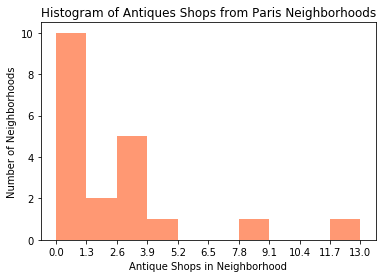

In [37]:
df = dfNeighborhood.copy()
dfHistogram = df['AntiqueShops'] 
count,bin_edges = np.histogram(dfHistogram)
dfHistogram.plot(
        kind='hist',
        xticks= bin_edges,
        alpha=0.8,
        color=['coral', 'darkslateblue', 'mediumseagreen'])
plt.title('Histogram of Antiques Shops from Paris Neighborhoods')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Antique Shops in Neighborhood')
plt.show()

We clearly see that most Neighborhoods has fewer Antiques Shops, then you have two Neighborhoods with a good density of antiques shops (8 and 13 shops respectively)


### Restaurants Density by Neighborhood

Lets use a histogram to show Restaurants shops concentration

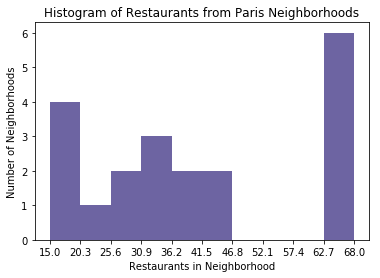

In [38]:
dfHistogram = df['Restaurants']#df[['AntiqueShops','Restaurants']]
count,bin_edges = np.histogram(dfHistogram)
dfHistogram.plot(
        kind='hist',
        xticks= bin_edges,
        alpha=0.8,
        color=[ 'darkslateblue', 'mediumseagreen'])
plt.title('Histogram of Restaurants from Paris Neighborhoods')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Restaurants in Neighborhood')
plt.show()

We clearly see that most Neighborhoods has between 15 and 40 restaurants
That's interesting, so we will go further on trying to compare this features

### Antiques Shops & Restaurants

At first sight it seems that this features are no correlated, but in order to see it clearly were going to compare them.
If no correlation exists, it will useful to see diferences between the two main features that the company needs to balance in order to achieve his objective

#### Lets seem them together in a Bar Chart

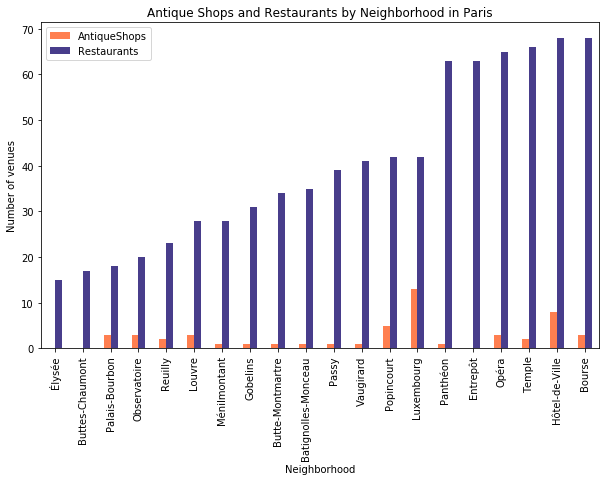

In [39]:
dfBar = df[['Neighborhood','AntiqueShops','Restaurants']].copy()
dfBar.sort_values(by='Restaurants', ascending=True, inplace=True)
dfBar.index=dfBar['Neighborhood']
dfBar.plot(kind='bar',
           figsize=(10, 6),
           #xticks=dfBar[['Neighborhood']],
           color=['coral', 'darkslateblue', 'mediumseagreen'])

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Antique Shops and Restaurants by Neighborhood in Paris') # add title to the plot

plt.show()


### Compare features on Scatter Plot

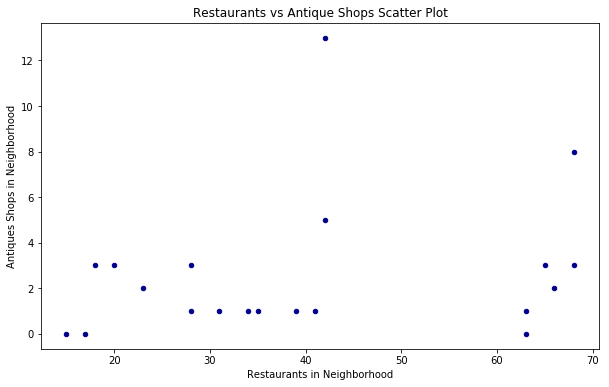

In [40]:
dfSP = df[['Neighborhood','AntiqueShops','Restaurants']].copy()
dfSP.plot(kind='scatter', y='AntiqueShops', x='Restaurants', figsize=(10, 6), color='darkblue')

plt.title('Restaurants vs Antique Shops Scatter Plot')
plt.xlabel('Restaurants in Neighborhood')
plt.ylabel('Antiques Shops in Neighborhood')

plt.show()

So, there is no correlation between this features, but it was useful to learn thath:
    * Luxembourg has most Antique Shops in Paris, with a high count of Restaurants
    * Hotel-de-ville has a second position in Antique Shops count, bus is in the top off restaurant counts

Lets go further and put this two Neighborhoods in contrast with all the Neiborhood in Paris:

## Luxembourg vs Hotel-de-ville

#### Box Plot to see Antique Shops by Neighborhood

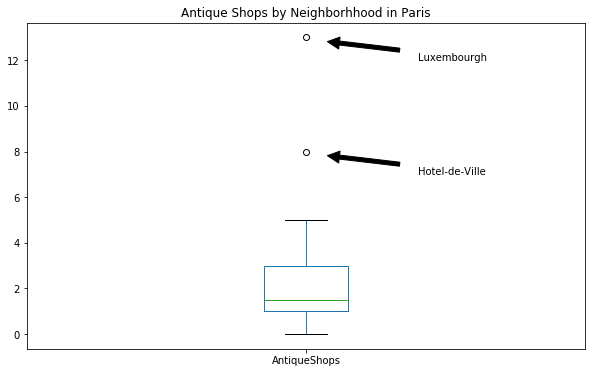

In [41]:
df[['AntiqueShops']].plot(kind='box' , figsize=(10, 6))
plt.title('Antique Shops by Neighborhhood in Paris')
# Annotate with text + Arrow
plt.annotate(
        'Luxembourgh', xy=(1.01, 12.9), xytext=(1.2, 12),
         arrowprops=dict(facecolor='black', shrink=0.15))
plt.annotate(
        'Hotel-de-Ville', xy=(1.01, 7.9), xytext=(1.2, 7),
         arrowprops=dict(facecolor='black', shrink=0.15))

plt.show()

#### Box Plot to see Restaurants by Neighborhood

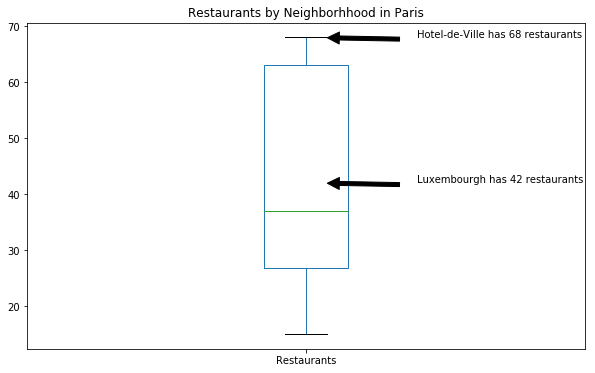

In [42]:
df[['Restaurants']].plot(kind='box' , figsize=(10, 6))
plt.title('Restaurants by Neighborhhood in Paris')
# Annotate with text + Arrow
plt.annotate(
        'Luxembourgh has 42 restaurants', xy=(1.01, 42), xytext=(1.2, 42),
         arrowprops=dict(facecolor='black', shrink=0.15))
plt.annotate(
        'Hotel-de-Ville has 68 restaurants', xy=(1.01, 68), xytext=(1.2, 68),
         arrowprops=dict(facecolor='black', shrink=0.15))

plt.show()

---

# 5. Clustering Neighborhoods on Restaurant categories basis

Food Cluster is important for the company because it defines the overall kind of food his competitors offer in each Neighborhood. Clustering Neighborhoods by this data bring us the capacity to compare the cuisine offer in wich the company prefer to set his branch

For this purpouse, where going to apply Machine Learning to calculate Clustering

First, let's use dummies and group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
# one hot encoding
onehot = pd.get_dummies(restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

# lets group by neighborhood
restaurants_grouped_onehot = onehot.groupby('Neighborhood').mean().reset_index()
#restaurants_grouped.head()
restaurants_grouped_onehot.shape



(20, 67)

Define a function to sort the venues in descending order.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurants_venues_sorted = pd.DataFrame(columns=columns)
restaurants_venues_sorted['Neighborhood'] = restaurants_grouped['Neighborhood']

for ind in np.arange(restaurants_grouped_onehot.shape[0]):
    restaurants_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped_onehot.iloc[ind, :], num_top_venues)

print(restaurants_venues_sorted.shape)
restaurants_venues_sorted.head()

(20, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hôtel-de-Ville,French Restaurant,Italian Restaurant,Lebanese Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Thai Restaurant,Korean Restaurant,Latin American Restaurant,Basque Restaurant
1,Bourse,French Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Korean Restaurant,Fast Food Restaurant,Ramen Restaurant,Mexican Restaurant,Tapas Restaurant,Udon Restaurant
2,Temple,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Indian Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant
3,Opéra,French Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Thai Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
4,Entrepôt,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Mediterranean Restaurant,African Restaurant,Thai Restaurant,Asian Restaurant,Seafood Restaurant


### Cluster Neighborhoods using k-means

Run k-means to cluster the neighborhood into 5 clusters

In [46]:
# set number of clusters
kclusters = 4

grouped_clustering = restaurants_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [47]:
# add clustering labels
restaurants_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

# merge grouped with add latitude/longitude for each neighborhood
merged = dfNeighborhood.join(restaurants_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head()  

,Neighborhood,Latitude,Longitude,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Louvre,48.861147,2.338028,3,28,0,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Lebanese Restaurant,Chinese Restaurant,Falafel Restaurant,Mediterranean Restaurant,Persian Restaurant
1,Bourse,48.868630,2.341474,3,68,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Korean Restaurant,Fast Food Restaurant,Ramen Restaurant,Mexican Restaurant,Tapas Restaurant,Udon Restaurant
2,Temple,48.866500,2.360708,2,66,1,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Indian Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant
3,Hôtel-de-Ville,48.856426,2.352528,8,68,1,French Restaurant,Italian Restaurant,Lebanese Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Thai Restaurant,Korean Restaurant,Latin American Restaurant,Basque Restaurant
4,Panthéon,48.846191,2.346079,1,63,1,French Restaurant,Italian Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Moroccan Restaurant,Chinese Restaurant,Sushi Restaurant,Basque Restaurant


visualize the resulting clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [49]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [50]:
# Examine Clusters
## Cluster 0
merged.loc[merged['Cluster'] == 0, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Louvre,3,28,0,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Lebanese Restaurant,Chinese Restaurant,Falafel Restaurant,Mediterranean Restaurant,Persian Restaurant
12,Gobelins,1,31,0,French Restaurant,Italian Restaurant,Asian Restaurant,Vietnamese Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Greek Restaurant
16,Batignolles-Monceau,1,35,0,French Restaurant,Thai Restaurant,Italian Restaurant,Modern European Restaurant,Fast Food Restaurant,Sushi Restaurant,Greek Restaurant,Gluten-free Restaurant,Indian Restaurant,Corsican Restaurant
17,Butte-Montmartre,1,34,0,French Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Korean Restaurant,Ramen Restaurant,Vietnamese Restaurant,Tapas Restaurant,Thai Restaurant,Taiwanese Restaurant
19,Ménilmontant,1,28,0,French Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,African Restaurant,American Restaurant,Korean Restaurant,Indian Restaurant


In [51]:
# Examine Clusters
## Cluster 1
merged.loc[merged['Cluster'] == 1, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bourse,3,68,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Korean Restaurant,Fast Food Restaurant,Ramen Restaurant,Mexican Restaurant,Tapas Restaurant,Udon Restaurant
2,Temple,2,66,1,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Indian Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant
3,Hôtel-de-Ville,8,68,1,French Restaurant,Italian Restaurant,Lebanese Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Thai Restaurant,Korean Restaurant,Latin American Restaurant,Basque Restaurant
4,Panthéon,1,63,1,French Restaurant,Italian Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Moroccan Restaurant,Chinese Restaurant,Sushi Restaurant,Basque Restaurant
8,Opéra,3,65,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Thai Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
9,Entrepôt,0,63,1,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Mediterranean Restaurant,African Restaurant,Thai Restaurant,Asian Restaurant,Seafood Restaurant


In [52]:
## Cluster 2
merged.loc[merged['Cluster'] == 2, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Palais-Bourbon,3,18,2,French Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Peruvian Restaurant,Vegetarian / Vegan Restaurant,Moroccan Restaurant,Thai Restaurant,Japanese Restaurant,Seafood Restaurant
7,Élysée,0,15,2,French Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Japanese Restaurant,Tapas Restaurant,Asian Restaurant,Southwestern French Restaurant,Eastern European Restaurant,English Restaurant
11,Reuilly,2,23,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Moroccan Restaurant,African Restaurant,Argentinian Restaurant,Comfort Food Restaurant
13,Observatoire,3,20,2,French Restaurant,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Lebanese Restaurant,Doner Restaurant,Cambodian Restaurant,Spanish Restaurant,Italian Restaurant,Asian Restaurant
18,Buttes-Chaumont,0,17,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Seafood Restaurant,Indian Restaurant,Korean Restaurant,Lebanese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant


In [53]:
## Cluster 3
merged.loc[merged['Cluster'] == 3, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Luxembourg,13,42,3,French Restaurant,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Jewish Restaurant,Falafel Restaurant,Vietnamese Restaurant
10,Popincourt,5,42,3,French Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Indonesian Restaurant,Fast Food Restaurant,Ramen Restaurant,Vietnamese Restaurant,Brazilian Restaurant
14,Vaugirard,1,41,3,French Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,American Restaurant,Ramen Restaurant,Breton Restaurant,Modern European Restaurant,Mexican Restaurant,Chinese Restaurant
15,Passy,1,39,3,French Restaurant,Japanese Restaurant,Italian Restaurant,Vietnamese Restaurant,African Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Asian Restaurant,Brazilian Restaurant,Greek Restaurant


In [54]:
## Cluster 4
merged.loc[merged['Cluster'] == 4, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [55]:
## Cluster 5
merged.loc[merged['Cluster'] == 5, merged.columns[[0] + list( range(3, merged.shape[1]))]]

,Neighborhood,AntiqueShops,Restaurants,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


---

## 6.  Analizing and Comparing Luxembourg's and  Hôtel-de-Ville's Clusters

So, first let's look for the clusters to which the neighborhoods of our interest belong 

In [56]:
dfC = merged[['Cluster']].copy()
dfC.index=merged['Neighborhood'].copy()
Luxembourg_Cluster = int(dfC.loc['Luxembourg','Cluster'])
HotelDeVille_Cluster = int(dfC.loc['Hôtel-de-Ville','Cluster'])
print('Luxembourg in on Cluster ' + str(Luxembourg_Cluster))
print('Hôtel-de-Ville in on Cluster ' + str(HotelDeVille_Cluster))


Luxembourg in on Cluster 3
Hôtel-de-Ville in on Cluster 1


### Analizing Luxembourg's Cluster

In [57]:
#Neighborhoods in Luxembourg Cluster
dfNeighborhoodMerged = dfNeighborhood.join(restaurants_venues_sorted.set_index('Neighborhood'), on='Neighborhood')[['Neighborhood','Latitude','Longitude','AntiqueShops','Restaurants','Cluster']]
dfLuxembourgCluster = dfNeighborhoodMerged[dfNeighborhoodMerged['Cluster']==Luxembourg_Cluster]
dfLuxembourgCluster

,Neighborhood,Latitude,Longitude,AntiqueShops,Restaurants,Cluster
5,Luxembourg,48.850433,2.332951,13,42,3
10,Popincourt,48.858416,2.379703,5,42,3
14,Vaugirard,48.841370,2.300383,1,41,3
15,Passy,48.857505,2.280983,1,39,3


As we can see, Luxembourg is the best choice between his cluster

Lets see what kind of food are offering this cluster

In [59]:
dfNeighborhoodRMergedLuxembourg = dfLuxembourgCluster.join(restaurants.set_index('Neighborhood'), on='Neighborhood')
dfNeighborhoodRMergedLuxembourg['Venue Category'].unique()

dfLuxembourg_Cats = dfNeighborhoodRMergedLuxembourg.groupby('Venue Category').count().sort_values(by=['Venue'], ascending=False).reset_index()
dfLuxembourg_Cats=dfLuxembourg_Cats[['Venue Category','Venue']]
dfLuxembourg_Cats = dfLuxembourg_Cats[0:7].reset_index(drop=True).copy()
dfLuxembourg_Cats.index =dfLuxembourg_Cats['Venue Category']
dfLuxembourg_Cats.drop(columns=['Venue Category'],inplace = True)
print('Luxembourg\'s Cluster Main Categories')

dfLuxembourg_Cats


Luxembourg's Cluster Main Categories


,Venue
Venue Category,
French Restaurant,49
Italian Restaurant,27
Japanese Restaurant,18
Seafood Restaurant,8
Thai Restaurant,6
Korean Restaurant,5
Chinese Restaurant,5


Lets visualize this in a pie chart

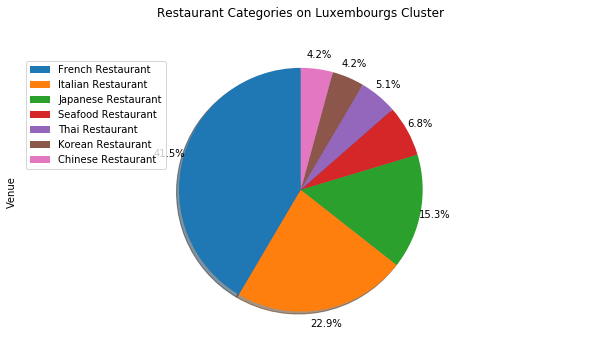

In [60]:
dfLuxembourg_Cats['Venue'].plot(kind='pie',
                            figsize=(10,5),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                 # turn off labels on pie chart
                            pctdistance=1.12,            
                            explode=[0, 0, 0, 0, 0, 0,0]        
                            )
# scale the title up by 12% to match pctdistance
plt.title('Restaurant Categories on Luxembourgs Cluster', y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=dfLuxembourg_Cats.index, loc='upper left') 
# show plot
plt.show()

### Analyzing Hôtel-de-Ville Cluster

In [61]:
#Neighborhoods in HotelDeVille  Cluster
dfNeighborhoodMerged = dfNeighborhood.join(restaurants_venues_sorted.set_index('Neighborhood'), on='Neighborhood')[['Neighborhood','Latitude','Longitude','AntiqueShops','Restaurants','Cluster']]
dfHotelDeVilleCluster = dfNeighborhoodMerged[dfNeighborhoodMerged['Cluster']==HotelDeVille_Cluster]
dfHotelDeVilleCluster

,Neighborhood,Latitude,Longitude,AntiqueShops,Restaurants,Cluster
1,Bourse,48.868630,2.341474,3,68,1
2,Temple,48.866500,2.360708,2,66,1
3,Hôtel-de-Ville,48.856426,2.352528,8,68,1
4,Panthéon,48.846191,2.346079,1,63,1
8,Opéra,48.870645,2.332330,3,65,1
9,Entrepôt,48.876106,2.359910,0,63,1


As we can see, Hotel de Ville is the best choice between his cluster

Lets see what kind of food are offering this cluster

In [62]:
dfNeighborhoodRMergedH = dfHotelDeVilleCluster.join(restaurants.set_index('Neighborhood'), on='Neighborhood')
dfNeighborhoodRMergedH['Venue Category'].unique()

dfHotelDeVilleCluster_Cats = dfNeighborhoodRMergedH.groupby('Venue Category').count().sort_values(by=['Venue'], ascending=False).reset_index()
dfHotelDeVilleCluster_Cats=dfHotelDeVilleCluster_Cats[['Venue Category','Venue']]
dfHotelDeVilleCluster_Cats = dfHotelDeVilleCluster_Cats[0:7].reset_index(drop=True).copy()
dfHotelDeVilleCluster_Cats.index =dfHotelDeVilleCluster_Cats['Venue Category']
dfHotelDeVilleCluster_Cats.drop(columns=['Venue Category'],inplace = True)
print('HotelDeVille\'s Cluster Main Categories')

dfHotelDeVilleCluster_Cats


HotelDeVille's Cluster Main Categories


,Venue
Venue Category,
French Restaurant,155
Italian Restaurant,35
Japanese Restaurant,32
Thai Restaurant,14
Indian Restaurant,11
Chinese Restaurant,10
Korean Restaurant,10


Lets visualize this in a pie chart

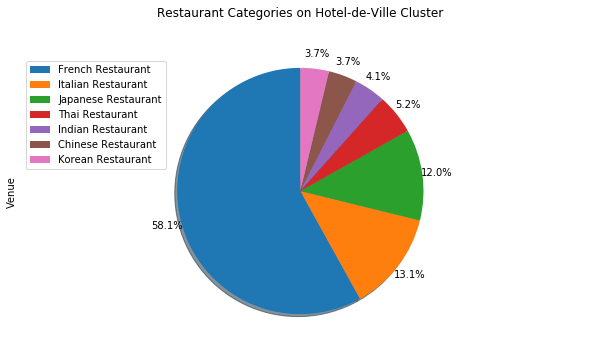

In [63]:
dfHotelDeVilleCluster_Cats['Venue'].plot(kind='pie',
                            figsize=(10,5),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                 # turn off labels on pie chart
                            pctdistance=1.12,            
                            explode=[0, 0, 0, 0, 0, 0,0]        
                            )
# scale the title up by 12% to match pctdistance
plt.title('Restaurant Categories on Hotel-de-Ville Cluster', y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=dfHotelDeVilleCluster_Cats.index, loc='upper left') 
# show plot
plt.show()

As we can see, Both Clusters offers similar types bus different proportions, in this case HotelDeVille's Cluster has more French and Regular Restaurants, and Luxembourg will be a more influenced by Italian Restaurants


---

# 7. Results

As a result we observe that although there is no relationship between the factors of Antique Shops and Restaurants, one can observe neighborhoods in which the concentration of antique shops is much greater than it could be, configuring an outliner that can be very advantageous for the company.

The grouping of neighbourhoods into clusters indicates that the Luxembourg neighbourhood is the one that best meets the above-mentioned factors, and has a cuisine offer similar to other similar neighbourhoods 


---

# 8. Discussion

In this project we discovered that the distribution of antique shops in Paris is not uniform,.

This allows us to observe that two districts of Paris can be highlighted as high concentration of antique shops.

In Luxembourg, we have a high presence of restaurants, always above the average of Paris.

We finally discarded hotel-villa because in the comparison, it is always a priority for the company to associate the brand "Midnight" with sectors of antique shops, although in hotel-villa it is of greater flow of customers

Another important observation obtained is the fact of classifying the type of restaurants that will make up the competition, distinguishing mainly standard restaurants (and French food), secondly Italian food and thirdly Oriental food.

We trust that this observation will be useful for the company to establish priorities when configuring the menu and the thematic environment in order to attract customers.




---

# 9. Conclusion

For all the above reasons, we recommend Luxembourg neighborhood as the best option for the new branch of "Midnight in Paris"

---

Thanks for Reading!